In [3]:
from dotenv import load_dotenv, find_dotenv 

load_dotenv(find_dotenv(), override = True)

True

In [4]:
from langchain_exa import ExaSearchRetriever
from langchain_openai import ChatOpenAI 

exa_search_retriever = ExaSearchRetriever(k = 1, highlights = False, type = "keyword") 

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)

In [5]:
from typing_extensions import TypedDict 
from typing import Annotated 
from operator import add 

class Custom_State(TypedDict): 
    question: str 
    answer: str 
    messages: Annotated[list[str], add]

In [52]:
def exa_search_tool_1(thesis_statement: str):
    """Search for context from online sources. 
    This search should use the whole thesis statement as the input.
    This tool should return context for the question that was asked and the accompanying url for the context. 
    Include the url at the end of the context.
    
    Args: 
        thesis_statement: input message
    """
    exa_search_retriever = ExaSearchRetriever(k = 1, highlights = False, type = "keyword") 
    output = exa_search_retriever.invoke(thesis_statement) 
    return output[0].page_content + output[0].metadata["url"]

In [53]:
llm_with_tools = ChatOpenAI(model = "gpt-4o-mini", temperature = 0).bind_tools([exa_search_tool_1])

In [54]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

sys_msg = SystemMessage(content="""
                        You are a helpful assistant tasked with analyzing text gathered from the web in order to aid the user in completing their research paper based on their thesis statement.
                        Use the entire thesis statement as the input for your web search. 
                        Return reasoning as to why the website, article, or academic paper found through the web search assists the user in writing their research paper. 
                        You must return specific quotations from the web search that the user can utilize within their own research paper. 
                        At the very end, include the url from the web search that was used to gather all of this information.
                        Display all reasoning in a numbered list format with the urls for each piece of reasoning at the end of the line. 
                        ONLY ACCEPT trust-worthy sources from the web search such as Google Scholar, JSTOR, ScienceDirect, and other academic databases. 
                        If a source does not seem to be trustworthy, skip the source and execute the search again, for a maximum of 3 iterations.
                        DO NOT write the user's research paper for them. """)

def assistant_node(state: Custom_State): 
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [55]:
def tool_conditional_edge(state: Custom_State): 
    if hasattr(state["messages"][-1], "tool_calls") and len(state["messages"][-1].tool_calls) > 0: 
        return "exa_tool"  
    else: 
        return END

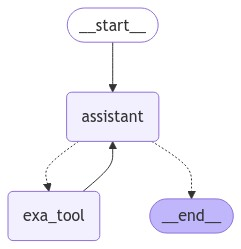

In [56]:
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode # tools_condition is not used here

builder = StateGraph(Custom_State)

builder.add_node("assistant", assistant_node) 
builder.add_node("exa_tool", ToolNode([exa_search_tool_1]))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tool_conditional_edge)
builder.add_edge("exa_tool", "assistant") 

graph = builder.compile() 

display(Image(graph.get_graph(xray = True).draw_mermaid_png()))

In [63]:
messages = [HumanMessage(content = "Immigration enriches receiving countries culturally and economically, outweighing any perceived social or economic burdens.")] 
complete_message = graph.invoke({"messages": messages})

In [64]:
print(complete_message) 
print("-" * 50) 
print(complete_message["messages"][-1].content)

{'messages': [HumanMessage(content='Immigration enriches receiving countries culturally and economically, outweighing any perceived social or economic burdens.', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qnDOaYtj8kPeSYOpyphkT5wI', 'function': {'arguments': '{"thesis_statement":"Immigration enriches receiving countries culturally and economically, outweighing any perceived social or economic burdens."}', 'name': 'exa_search_tool_1'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 327, 'total_tokens': 365, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-aca94f6f-59b5-489f-a1d1-f742fa1fd476-0', tool_calls=[{'name': 'ex

In [65]:
for message in complete_message["messages"]: 
    message.pretty_print()

================================ Human Message =================================

Immigration enriches receiving countries culturally and economically, outweighing any perceived social or economic burdens.
================================== Ai Message ==================================
Tool Calls:
  exa_search_tool_1 (call_qnDOaYtj8kPeSYOpyphkT5wI)
 Call ID: call_qnDOaYtj8kPeSYOpyphkT5wI
  Args:
    thesis_statement: Immigration enriches receiving countries culturally and economically, outweighing any perceived social or economic burdens.
================================= Tool Message =================================
Name: exa_search_tool_1

The rich have many assets; the poor have only one—their labor. Because good jobs are slow to come to the poor, the poor must move to find productive employment. Migration is, therefore, the most effective way to reduce poverty and share prosperity, the twin goals of the World Bank. Not surprisingly, all development experiences and growth episodes 